In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam


In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
MAIN_DIR = "./Downloads/brain dataset/brain_tumor_dataset/yes"


In [4]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels


In [5]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape


((155, 128, 128), (155,))

In [6]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)


In [7]:
X_train = data[idxs]
X_train.shape


(20, 128, 128)

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape


(20, 128, 128, 1)

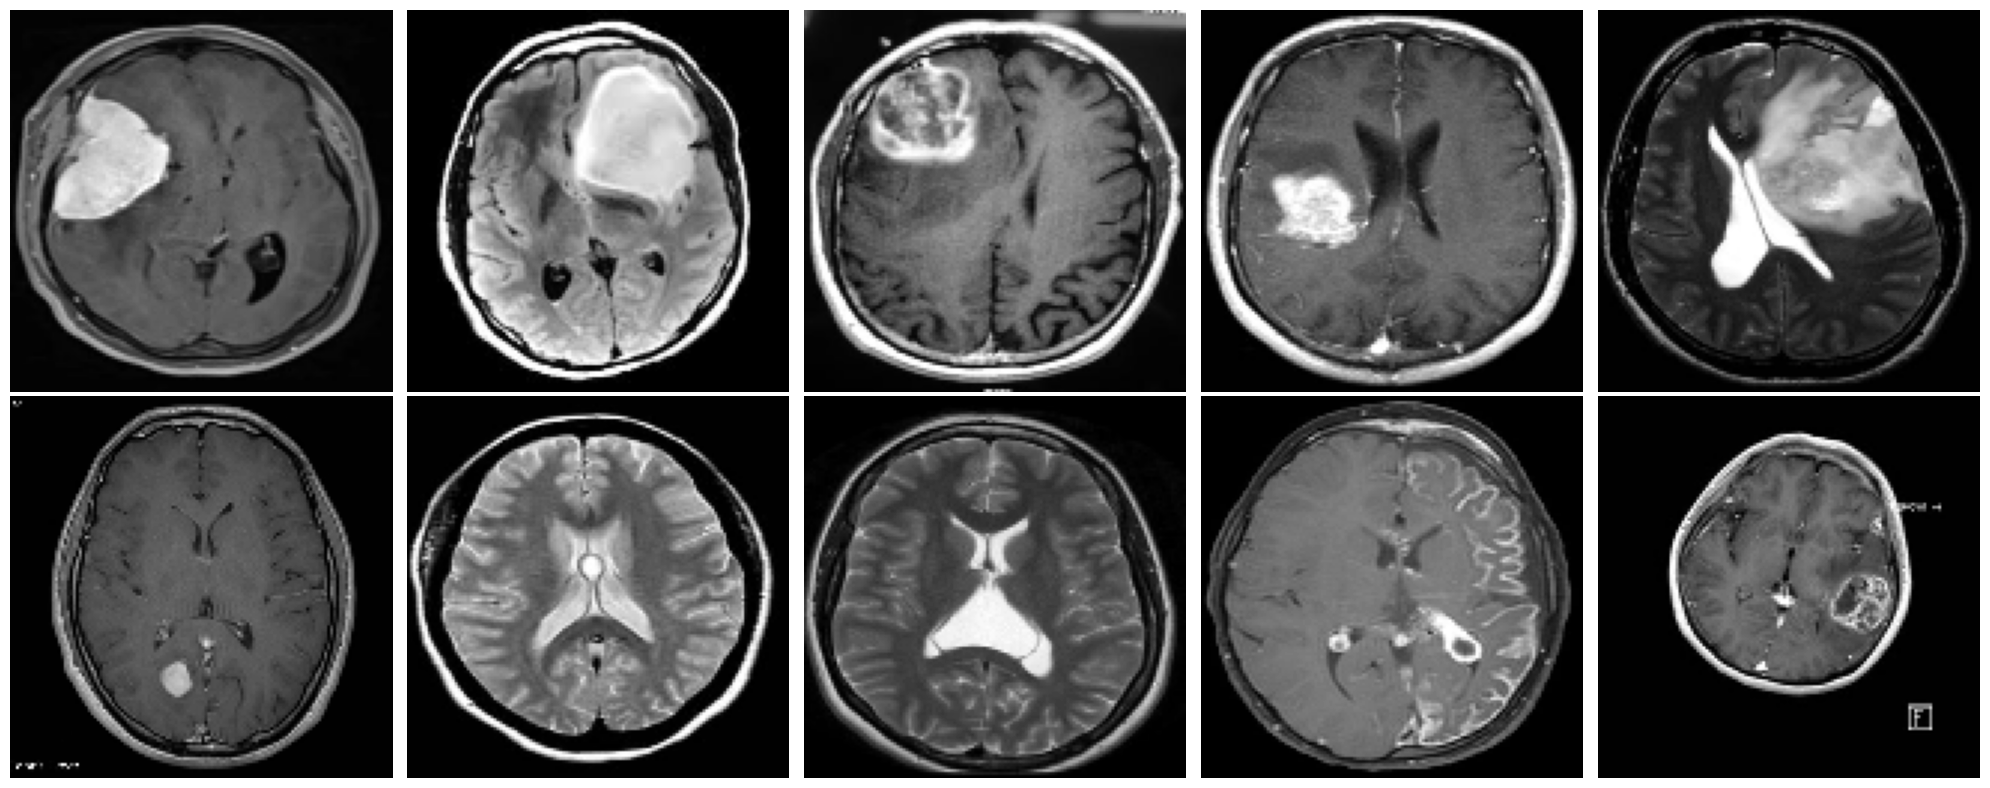

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          65,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 582,785 (2.22 MB)

 Trainable params: 582,785 (2.22 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 262144)              │      26,476,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 64, 64, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 128)       │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,265,281 (104.01 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 0 (0.00 B)

The Combined Network:



Model: "gan_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ generator (Sequential)               │ (None, 128, 128, 1)         │      27,265,281 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ discriminator (Sequential)           │ (None, 1)                   │         582,785 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,848,066 (106.23 MB)

 Trainable params: 27,265,281 (104.01 MB)

 Non-trainable params: 582,785 (2.22 MB)

In [13]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

  0%|                                                                                         | 0/3750 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


  0%|                                                                               | 1/3750 [00:03<4:00:31,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


  0%|                                                                               | 2/3750 [00:05<2:34:40,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  0%|                                                                               | 3/3750 [00:06<2:02:21,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  0%|                                                                               | 4/3750 [00:08<1:46:48,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  0%|                                                                               | 5/3750 [00:09<1:36:25,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|▏                                                                              | 6/3750 [00:10<1:30:33,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  0%|▏                                                                              | 7/3750 [00:12<1:30:48,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  0%|▏                                                                              | 8/3750 [00:13<1:26:44,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  0%|▏                                                                              | 9/3750 [00:14<1:25:47,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  0%|▏                                                                             | 10/3750 [00:15<1:22:57,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  0%|▏                                                                             | 11/3750 [00:17<1:22:26,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  0%|▏                                                                             | 12/3750 [00:18<1:24:32,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  0%|▎                                                                             | 13/3750 [00:19<1:24:39,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|▎                                                                             | 14/3750 [00:21<1:23:03,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  0%|▎                                                                             | 15/3750 [00:22<1:20:53,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|▎                                                                             | 16/3750 [00:23<1:20:53,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  0%|▎                                                                             | 17/3750 [00:25<1:20:47,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  0%|▎                                                                             | 18/3750 [00:26<1:23:51,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▍                                                                             | 19/3750 [00:27<1:21:55,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  1%|▍                                                                             | 20/3750 [00:28<1:19:36,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▍                                                                             | 21/3750 [00:30<1:18:07,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|▍                                                                             | 22/3750 [00:31<1:18:18,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▍                                                                             | 23/3750 [00:32<1:17:48,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  1%|▍                                                                             | 24/3750 [00:33<1:18:30,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  1%|▌                                                                             | 25/3750 [00:35<1:19:02,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  1%|▌                                                                             | 26/3750 [00:36<1:20:04,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  1%|▌                                                                             | 27/3750 [00:37<1:18:28,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▌                                                                             | 28/3750 [00:39<1:19:27,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  1%|▌                                                                             | 29/3750 [00:40<1:18:41,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  1%|▌                                                                             | 30/3750 [00:41<1:22:19,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  1%|▋                                                                             | 31/3750 [00:43<1:20:40,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  1%|▋                                                                             | 32/3750 [00:44<1:17:16,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  1%|▋                                                                             | 33/3750 [00:45<1:15:49,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  1%|▋                                                                             | 34/3750 [00:46<1:13:46,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


  1%|▋                                                                             | 35/3750 [00:47<1:17:32,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  1%|▋                                                                             | 36/3750 [00:49<1:17:12,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▊                                                                             | 37/3750 [00:50<1:17:19,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▊                                                                             | 38/3750 [00:51<1:18:59,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|▊                                                                             | 39/3750 [00:52<1:19:18,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|▊                                                                             | 40/3750 [00:54<1:20:09,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  1%|▊                                                                             | 41/3750 [00:55<1:21:36,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                             | 42/3750 [00:56<1:20:42,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  1%|▉                                                                             | 43/3750 [00:58<1:19:46,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▉                                                                             | 44/3750 [00:59<1:19:47,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  1%|▉                                                                             | 45/3750 [01:00<1:18:39,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|▉                                                                             | 46/3750 [01:02<1:18:50,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  1%|▉                                                                             | 47/3750 [01:05<1:57:45,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  1%|▉                                                                             | 48/3750 [01:06<1:47:58,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  1%|█                                                                             | 49/3750 [01:08<1:39:41,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


  1%|█                                                                             | 50/3750 [01:09<1:35:29,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|█                                                                             | 51/3750 [01:10<1:34:31,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  1%|█                                                                             | 52/3750 [01:12<1:32:55,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


  1%|█                                                                             | 53/3750 [01:13<1:29:04,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  1%|█                                                                             | 54/3750 [01:14<1:24:39,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  1%|█▏                                                                            | 55/3750 [01:16<1:22:31,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  1%|█▏                                                                            | 56/3750 [01:17<1:22:03,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  2%|█▏                                                                            | 57/3750 [01:18<1:22:12,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|█▏                                                                            | 58/3750 [01:20<1:22:23,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▏                                                                            | 59/3750 [01:21<1:22:17,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  2%|█▏                                                                            | 60/3750 [01:22<1:24:31,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  2%|█▎                                                                            | 61/3750 [01:24<1:22:12,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▎                                                                            | 62/3750 [01:25<1:21:21,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  2%|█▎                                                                            | 63/3750 [01:26<1:18:42,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▎                                                                            | 64/3750 [01:27<1:17:38,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  2%|█▎                                                                            | 65/3750 [01:29<1:20:10,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  2%|█▎                                                                            | 66/3750 [01:30<1:26:46,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  2%|█▍                                                                            | 67/3750 [01:32<1:26:47,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  2%|█▍                                                                            | 68/3750 [01:33<1:24:41,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  2%|█▍                                                                            | 69/3750 [01:35<1:25:34,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  2%|█▍                                                                            | 70/3750 [01:36<1:25:53,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  2%|█▍                                                                            | 71/3750 [01:38<1:31:13,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  2%|█▍                                                                            | 72/3750 [01:39<1:35:31,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  2%|█▌                                                                            | 73/3750 [01:41<1:38:45,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  2%|█▌                                                                            | 74/3750 [01:43<1:38:07,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  2%|█▌                                                                            | 75/3750 [01:44<1:37:00,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▌                                                                            | 76/3750 [01:46<1:35:39,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  2%|█▌                                                                            | 77/3750 [01:48<1:38:18,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  2%|█▌                                                                            | 78/3750 [01:49<1:37:47,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|█▋                                                                            | 79/3750 [01:51<1:37:58,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  2%|█▋                                                                            | 80/3750 [01:52<1:36:58,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  2%|█▋                                                                            | 81/3750 [01:54<1:32:57,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  2%|█▋                                                                            | 82/3750 [01:55<1:30:08,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  2%|█▋                                                                            | 83/3750 [01:56<1:28:44,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|█▋                                                                            | 84/3750 [01:58<1:32:58,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  2%|█▊                                                                            | 85/3750 [02:00<1:33:59,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  2%|█▊                                                                            | 86/3750 [02:01<1:38:04,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  2%|█▊                                                                            | 87/3750 [02:03<1:39:33,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  2%|█▊                                                                            | 88/3750 [02:05<1:42:23,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  2%|█▊                                                                            | 89/3750 [02:07<1:45:24,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  2%|█▊                                                                            | 90/3750 [02:08<1:43:40,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  2%|█▉                                                                            | 91/3750 [02:10<1:39:18,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  2%|█▉                                                                            | 92/3750 [02:11<1:38:10,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  2%|█▉                                                                            | 93/3750 [02:13<1:35:21,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|█▉                                                                            | 94/3750 [02:14<1:33:26,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  3%|█▉                                                                            | 95/3750 [02:16<1:35:21,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  3%|█▉                                                                            | 96/3750 [02:18<1:35:03,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██                                                                            | 97/3750 [02:19<1:36:23,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|██                                                                            | 98/3750 [02:21<1:36:06,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|██                                                                            | 99/3750 [02:22<1:32:33,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|██                                                                           | 100/3750 [02:24<1:31:44,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  3%|██                                                                           | 101/3750 [02:25<1:31:14,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  3%|██                                                                           | 102/3750 [02:26<1:27:21,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██                                                                           | 103/3750 [02:28<1:30:33,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|██▏                                                                          | 104/3750 [02:30<1:33:54,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|██▏                                                                          | 105/3750 [02:31<1:34:52,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  3%|██▏                                                                          | 106/3750 [02:33<1:35:27,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  3%|██▏                                                                          | 107/3750 [02:34<1:33:59,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  3%|██▏                                                                          | 108/3750 [02:36<1:34:41,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|██▏                                                                          | 109/3750 [02:37<1:34:13,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  3%|██▎                                                                          | 110/3750 [02:39<1:34:00,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▎                                                                          | 111/3750 [02:40<1:30:40,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██▎                                                                          | 112/3750 [02:42<1:28:56,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██▎                                                                          | 113/3750 [02:43<1:26:40,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▎                                                                          | 114/3750 [02:44<1:24:55,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  3%|██▎                                                                          | 115/3750 [02:46<1:27:53,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  3%|██▍                                                                          | 116/3750 [02:48<1:30:36,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  3%|██▍                                                                          | 117/3750 [02:49<1:32:09,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  3%|██▍                                                                          | 118/3750 [02:51<1:31:46,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|██▍                                                                          | 119/3750 [02:52<1:28:52,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  3%|██▍                                                                          | 120/3750 [02:53<1:27:41,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▍                                                                          | 121/3750 [02:55<1:24:42,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  3%|██▌                                                                          | 122/3750 [02:56<1:22:58,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▌                                                                          | 123/3750 [02:57<1:21:21,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


  3%|██▌                                                                          | 124/3750 [02:59<1:21:09,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▌                                                                          | 125/3750 [03:00<1:25:00,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  3%|██▌                                                                          | 126/3750 [03:02<1:28:12,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  3%|██▌                                                                          | 127/3750 [03:03<1:28:44,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|██▋                                                                          | 128/3750 [03:05<1:27:19,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  3%|██▋                                                                          | 129/3750 [03:06<1:27:47,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  3%|██▋                                                                          | 130/3750 [03:08<1:28:33,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  3%|██▋                                                                          | 131/3750 [03:09<1:28:17,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  4%|██▋                                                                          | 132/3750 [03:11<1:26:40,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  4%|██▋                                                                          | 133/3750 [03:12<1:26:20,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▊                                                                          | 134/3750 [03:13<1:27:55,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|██▊                                                                          | 135/3750 [03:15<1:26:46,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  4%|██▊                                                                          | 136/3750 [03:17<1:32:31,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|██▊                                                                          | 137/3750 [03:18<1:34:04,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


  4%|██▊                                                                          | 138/3750 [03:20<1:31:02,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  4%|██▊                                                                          | 139/3750 [03:21<1:31:34,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|██▊                                                                          | 140/3750 [03:23<1:32:59,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|██▉                                                                          | 141/3750 [03:24<1:34:19,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|██▉                                                                          | 142/3750 [03:26<1:33:15,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▉                                                                          | 143/3750 [03:27<1:28:26,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|██▉                                                                          | 144/3750 [03:28<1:25:21,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  4%|██▉                                                                          | 145/3750 [03:30<1:24:09,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|██▉                                                                          | 146/3750 [03:31<1:23:46,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|███                                                                          | 147/3750 [03:33<1:27:22,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|███                                                                          | 148/3750 [03:34<1:31:03,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███                                                                          | 149/3750 [03:36<1:33:04,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|███                                                                          | 150/3750 [03:38<1:33:18,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███                                                                          | 151/3750 [03:39<1:33:24,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  4%|███                                                                          | 152/3750 [03:41<1:34:29,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  4%|███▏                                                                         | 153/3750 [03:42<1:34:05,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  4%|███▏                                                                         | 154/3750 [03:44<1:31:21,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  4%|███▏                                                                         | 155/3750 [03:45<1:28:27,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▏                                                                         | 156/3750 [03:47<1:30:46,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  4%|███▏                                                                         | 157/3750 [03:48<1:29:21,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  4%|███▏                                                                         | 158/3750 [03:50<1:28:42,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  4%|███▎                                                                         | 159/3750 [03:51<1:29:12,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  4%|███▎                                                                         | 160/3750 [03:53<1:29:21,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  4%|███▎                                                                         | 161/3750 [03:54<1:28:36,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  4%|███▎                                                                         | 162/3750 [03:56<1:29:34,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  4%|███▎                                                                         | 163/3750 [03:57<1:30:10,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  4%|███▎                                                                         | 164/3750 [03:59<1:28:08,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  4%|███▍                                                                         | 165/3750 [04:00<1:31:04,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  4%|███▍                                                                         | 166/3750 [04:02<1:41:10,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  4%|███▍                                                                         | 167/3750 [04:04<1:40:37,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  4%|███▍                                                                         | 168/3750 [04:06<1:37:59,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  5%|███▍                                                                         | 169/3750 [04:07<1:36:02,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  5%|███▍                                                                         | 170/3750 [04:09<1:34:57,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▌                                                                         | 171/3750 [04:10<1:36:02,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  5%|███▌                                                                         | 172/3750 [04:12<1:33:22,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  5%|███▌                                                                         | 173/3750 [04:13<1:31:19,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                         | 174/3750 [04:15<1:27:51,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▌                                                                         | 175/3750 [04:16<1:24:32,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▌                                                                         | 176/3750 [04:17<1:24:17,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  5%|███▋                                                                         | 177/3750 [04:19<1:22:25,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|███▋                                                                         | 178/3750 [04:20<1:22:18,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  5%|███▋                                                                         | 179/3750 [04:21<1:21:53,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  5%|███▋                                                                         | 180/3750 [04:23<1:24:10,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  5%|███▋                                                                         | 181/3750 [04:24<1:23:33,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  5%|███▋                                                                         | 182/3750 [04:26<1:22:15,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|███▊                                                                         | 183/3750 [04:27<1:22:11,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  5%|███▊                                                                         | 184/3750 [04:28<1:22:53,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  5%|███▊                                                                         | 185/3750 [04:30<1:24:21,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▊                                                                         | 186/3750 [04:31<1:26:28,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  5%|███▊                                                                         | 187/3750 [04:33<1:28:38,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|███▊                                                                         | 188/3750 [04:35<1:35:02,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  5%|███▉                                                                         | 189/3750 [04:41<2:57:54,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|███▉                                                                         | 190/3750 [04:43<2:31:32,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  5%|███▉                                                                         | 191/3750 [04:44<2:13:46,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|███▉                                                                         | 192/3750 [04:46<2:03:12,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  5%|███▉                                                                         | 193/3750 [04:48<1:57:18,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  5%|███▉                                                                         | 194/3750 [04:50<2:04:18,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  5%|████                                                                         | 195/3750 [04:52<2:01:35,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  5%|████                                                                         | 196/3750 [04:54<1:59:02,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  5%|████                                                                         | 197/3750 [04:56<1:57:15,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  5%|████                                                                         | 198/3750 [04:58<1:55:53,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|████                                                                         | 199/3750 [04:59<1:54:17,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  5%|████                                                                         | 200/3750 [05:01<1:50:13,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████▏                                                                        | 201/3750 [05:03<1:48:57,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


  5%|████▏                                                                        | 202/3750 [05:05<1:49:53,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


  5%|████▏                                                                        | 203/3750 [05:07<1:46:28,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  5%|████▏                                                                        | 204/3750 [05:08<1:45:54,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  5%|████▏                                                                        | 205/3750 [05:10<1:45:41,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  5%|████▏                                                                        | 206/3750 [05:12<1:44:25,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  6%|████▎                                                                        | 207/3750 [05:13<1:43:16,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


  6%|████▎                                                                        | 208/3750 [05:15<1:44:29,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▎                                                                        | 209/3750 [05:17<1:48:23,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


  6%|████▎                                                                        | 210/3750 [05:19<1:50:50,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  6%|████▎                                                                        | 211/3750 [05:21<1:50:37,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  6%|████▎                                                                        | 212/3750 [05:23<1:50:11,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|████▎                                                                        | 213/3750 [05:25<1:50:39,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|████▍                                                                        | 214/3750 [05:27<1:53:18,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  6%|████▍                                                                        | 215/3750 [05:29<1:54:35,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|████▍                                                                        | 216/3750 [05:31<1:54:14,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  6%|████▍                                                                        | 217/3750 [05:33<1:53:06,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  6%|████▍                                                                        | 218/3750 [05:35<1:51:40,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  6%|████▍                                                                        | 219/3750 [05:36<1:50:53,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  6%|████▌                                                                        | 220/3750 [05:38<1:51:38,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  6%|████▌                                                                        | 221/3750 [05:40<1:50:28,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▌                                                                        | 222/3750 [05:42<1:46:16,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


  6%|████▌                                                                        | 223/3750 [05:44<1:54:08,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  6%|████▌                                                                        | 224/3750 [05:46<1:51:07,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  6%|████▌                                                                        | 225/3750 [05:48<1:50:23,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  6%|████▋                                                                        | 226/3750 [05:49<1:46:14,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


  6%|████▋                                                                        | 227/3750 [05:51<1:39:38,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  6%|████▋                                                                        | 228/3750 [05:52<1:34:09,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  6%|████▋                                                                        | 229/3750 [05:54<1:32:03,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▋                                                                        | 230/3750 [05:55<1:31:05,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  6%|████▋                                                                        | 231/3750 [05:57<1:29:59,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  6%|████▊                                                                        | 232/3750 [05:58<1:27:17,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▊                                                                        | 233/3750 [05:59<1:25:38,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  6%|████▊                                                                        | 234/3750 [06:01<1:24:07,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▊                                                                        | 235/3750 [06:02<1:23:55,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                        | 236/3750 [06:04<1:22:26,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  6%|████▊                                                                        | 237/3750 [06:05<1:21:31,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  6%|████▉                                                                        | 238/3750 [06:06<1:20:55,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  6%|████▉                                                                        | 239/3750 [06:08<1:19:16,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|████▉                                                                        | 240/3750 [06:09<1:19:23,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▉                                                                        | 241/3750 [06:10<1:18:15,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  6%|████▉                                                                        | 242/3750 [06:12<1:18:30,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  6%|████▉                                                                        | 243/3750 [06:13<1:20:12,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  7%|█████                                                                        | 244/3750 [06:14<1:21:02,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████                                                                        | 245/3750 [06:16<1:21:44,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  7%|█████                                                                        | 246/3750 [06:17<1:21:19,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|█████                                                                        | 247/3750 [06:19<1:23:10,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████                                                                        | 248/3750 [06:20<1:27:12,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████                                                                        | 249/3750 [06:22<1:28:49,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  7%|█████▏                                                                       | 250/3750 [06:24<1:28:29,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  7%|█████▏                                                                       | 251/3750 [06:25<1:25:11,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|█████▏                                                                       | 252/3750 [06:26<1:22:30,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  7%|█████▏                                                                       | 253/3750 [06:28<1:24:59,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  7%|█████▏                                                                       | 254/3750 [06:29<1:24:24,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▏                                                                       | 255/3750 [06:30<1:20:50,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|█████▎                                                                       | 256/3750 [06:32<1:21:52,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▎                                                                       | 257/3750 [06:33<1:22:23,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▎                                                                       | 258/3750 [06:35<1:24:22,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  7%|█████▎                                                                       | 259/3750 [06:37<1:29:42,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  7%|█████▎                                                                       | 260/3750 [06:38<1:32:10,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▎                                                                       | 261/3750 [06:40<1:28:31,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  7%|█████▍                                                                       | 262/3750 [06:41<1:25:13,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  7%|█████▍                                                                       | 263/3750 [06:42<1:21:59,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▍                                                                       | 264/3750 [06:44<1:20:32,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|█████▍                                                                       | 265/3750 [06:45<1:18:38,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|█████▍                                                                       | 266/3750 [06:46<1:17:55,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  7%|█████▍                                                                       | 267/3750 [06:48<1:18:33,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  7%|█████▌                                                                       | 268/3750 [06:49<1:24:03,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  7%|█████▌                                                                       | 269/3750 [06:51<1:32:24,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  7%|█████▌                                                                       | 270/3750 [06:53<1:34:38,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  7%|█████▌                                                                       | 271/3750 [06:54<1:32:58,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  7%|█████▌                                                                       | 272/3750 [06:56<1:30:42,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


  7%|█████▌                                                                       | 273/3750 [06:57<1:25:43,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  7%|█████▋                                                                       | 274/3750 [06:59<1:25:53,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▋                                                                       | 275/3750 [07:00<1:23:33,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  7%|█████▋                                                                       | 276/3750 [07:02<1:25:14,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  7%|█████▋                                                                       | 277/3750 [07:03<1:27:37,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  7%|█████▋                                                                       | 278/3750 [07:05<1:29:20,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  7%|█████▋                                                                       | 279/3750 [07:06<1:25:37,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▋                                                                       | 280/3750 [07:07<1:20:50,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  7%|█████▊                                                                       | 281/3750 [07:09<1:19:54,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  8%|█████▊                                                                       | 282/3750 [07:10<1:18:44,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|█████▊                                                                       | 283/3750 [07:11<1:21:42,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  8%|█████▊                                                                       | 284/3750 [07:13<1:23:00,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|█████▊                                                                       | 285/3750 [07:15<1:26:57,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  8%|█████▊                                                                       | 286/3750 [07:16<1:28:50,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|█████▉                                                                       | 287/3750 [07:18<1:30:30,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


  8%|█████▉                                                                       | 288/3750 [07:20<1:32:36,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  8%|█████▉                                                                       | 289/3750 [07:21<1:35:36,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  8%|█████▉                                                                       | 290/3750 [07:23<1:31:34,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|█████▉                                                                       | 291/3750 [07:24<1:27:58,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|█████▉                                                                       | 292/3750 [07:26<1:25:03,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  8%|██████                                                                       | 293/3750 [07:27<1:20:59,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


  8%|██████                                                                       | 294/3750 [07:28<1:20:44,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  8%|██████                                                                       | 295/3750 [07:29<1:18:38,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


  8%|██████                                                                       | 296/3750 [07:31<1:19:41,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  8%|██████                                                                       | 297/3750 [07:32<1:21:21,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████                                                                       | 298/3750 [07:34<1:21:08,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|██████▏                                                                      | 299/3750 [07:35<1:19:49,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  8%|██████▏                                                                      | 300/3750 [07:36<1:18:00,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████▏                                                                      | 301/3750 [07:38<1:17:48,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


  8%|██████▏                                                                      | 302/3750 [07:39<1:20:59,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  8%|██████▏                                                                      | 303/3750 [07:41<1:19:02,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  8%|██████▏                                                                      | 304/3750 [07:42<1:18:37,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  8%|██████▎                                                                      | 305/3750 [07:43<1:18:13,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▎                                                                      | 306/3750 [07:45<1:20:05,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████▎                                                                      | 307/3750 [07:46<1:19:14,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████▎                                                                      | 308/3750 [07:47<1:18:23,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|██████▎                                                                      | 309/3750 [07:49<1:17:15,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|██████▎                                                                      | 310/3750 [07:50<1:16:52,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  8%|██████▍                                                                      | 311/3750 [07:51<1:16:27,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|██████▍                                                                      | 312/3750 [07:53<1:15:53,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|██████▍                                                                      | 313/3750 [07:54<1:15:31,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  8%|██████▍                                                                      | 314/3750 [07:55<1:17:23,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  8%|██████▍                                                                      | 315/3750 [07:57<1:19:10,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|██████▍                                                                      | 316/3750 [07:58<1:17:34,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  8%|██████▌                                                                      | 317/3750 [08:00<1:18:11,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████▌                                                                      | 318/3750 [08:01<1:16:27,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  9%|██████▌                                                                      | 319/3750 [08:02<1:17:29,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|██████▌                                                                      | 320/3750 [08:04<1:17:42,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|██████▌                                                                      | 321/3750 [08:05<1:20:09,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|██████▌                                                                      | 322/3750 [08:07<1:21:21,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|██████▋                                                                      | 323/3750 [08:08<1:21:17,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|██████▋                                                                      | 324/3750 [08:10<1:25:11,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  9%|██████▋                                                                      | 325/3750 [08:11<1:29:50,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  9%|██████▋                                                                      | 326/3750 [08:13<1:37:40,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  9%|██████▋                                                                      | 327/3750 [08:15<1:41:57,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|██████▋                                                                      | 328/3750 [08:17<1:41:38,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  9%|██████▊                                                                      | 329/3750 [08:19<1:35:40,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  9%|██████▊                                                                      | 330/3750 [08:20<1:32:34,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  9%|██████▊                                                                      | 331/3750 [08:22<1:30:10,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  9%|██████▊                                                                      | 332/3750 [08:23<1:25:59,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  9%|██████▊                                                                      | 333/3750 [08:24<1:23:34,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|██████▊                                                                      | 334/3750 [08:26<1:20:25,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|██████▉                                                                      | 335/3750 [08:27<1:22:21,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  9%|██████▉                                                                      | 336/3750 [08:29<1:23:18,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|██████▉                                                                      | 337/3750 [08:30<1:23:02,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|██████▉                                                                      | 338/3750 [08:31<1:21:45,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|██████▉                                                                      | 339/3750 [08:33<1:19:47,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  9%|██████▉                                                                      | 340/3750 [08:34<1:20:26,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  9%|███████                                                                      | 341/3750 [08:36<1:19:14,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|███████                                                                      | 342/3750 [08:37<1:19:47,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|███████                                                                      | 343/3750 [08:38<1:19:40,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  9%|███████                                                                      | 344/3750 [08:40<1:19:26,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  9%|███████                                                                      | 345/3750 [08:41<1:18:33,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|███████                                                                      | 346/3750 [08:43<1:20:43,  1.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|███████▏                                                                     | 347/3750 [08:44<1:19:54,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|███████▏                                                                     | 348/3750 [08:45<1:20:07,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|███████▏                                                                     | 349/3750 [08:47<1:19:50,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|███████▏                                                                     | 350/3750 [08:48<1:17:09,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|███████▏                                                                     | 351/3750 [08:49<1:17:41,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  9%|███████▏                                                                     | 352/3750 [08:51<1:17:31,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


  9%|███████▏                                                                     | 353/3750 [08:52<1:17:47,  1.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  9%|███████▎                                                                     | 354/3750 [08:54<1:17:03,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|███████▎                                                                     | 355/3750 [08:55<1:17:05,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


  9%|███████▎                                                                     | 356/3750 [08:56<1:18:29,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 10%|███████▎                                                                     | 357/3750 [08:58<1:18:27,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 10%|███████▎                                                                     | 358/3750 [08:59<1:19:15,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 10%|███████▎                                                                     | 359/3750 [09:01<1:19:12,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|███████▍                                                                     | 360/3750 [09:02<1:18:10,  1.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|███████▍                                                                     | 361/3750 [09:03<1:19:06,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|███████▍                                                                     | 362/3750 [09:09<2:28:28,  2.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 10%|███████▍                                                                     | 363/3750 [09:10<2:06:17,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▍                                                                     | 364/3750 [09:12<1:53:36,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 10%|███████▍                                                                     | 365/3750 [09:13<1:44:40,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|███████▌                                                                     | 366/3750 [09:15<1:41:50,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 10%|███████▌                                                                     | 367/3750 [09:17<1:39:05,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 10%|███████▌                                                                     | 368/3750 [09:19<1:43:04,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 10%|███████▌                                                                     | 369/3750 [09:20<1:44:42,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 10%|███████▌                                                                     | 370/3750 [09:22<1:42:59,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|███████▌                                                                     | 371/3750 [09:24<1:35:06,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 10%|███████▋                                                                     | 372/3750 [09:25<1:31:47,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 10%|███████▋                                                                     | 373/3750 [09:27<1:28:54,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 10%|███████▋                                                                     | 374/3750 [09:28<1:25:23,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 10%|███████▋                                                                     | 375/3750 [09:29<1:23:50,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 10%|███████▋                                                                     | 376/3750 [09:31<1:22:47,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 10%|███████▋                                                                     | 377/3750 [09:32<1:21:03,  1.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 10%|███████▊                                                                     | 378/3750 [09:34<1:22:51,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 10%|███████▊                                                                     | 379/3750 [09:35<1:22:38,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 10%|███████▊                                                                     | 380/3750 [09:37<1:22:01,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▊                                                                     | 381/3750 [09:38<1:22:24,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 10%|███████▊                                                                     | 382/3750 [09:40<1:23:43,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 10%|███████▊                                                                     | 383/3750 [09:41<1:24:38,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 10%|███████▉                                                                     | 384/3750 [09:43<1:27:51,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 10%|███████▉                                                                     | 385/3750 [09:44<1:27:19,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|███████▉                                                                     | 386/3750 [09:46<1:29:44,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 10%|███████▉                                                                     | 387/3750 [09:48<1:38:23,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 10%|███████▉                                                                     | 388/3750 [09:50<1:44:57,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 10%|███████▉                                                                     | 389/3750 [09:52<1:48:50,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|████████                                                                     | 390/3750 [09:54<1:50:29,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 10%|████████                                                                     | 391/3750 [09:56<1:49:23,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 10%|████████                                                                     | 392/3750 [09:58<1:46:09,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|████████                                                                     | 393/3750 [10:00<1:46:07,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████                                                                     | 394/3750 [10:02<1:50:14,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|████████                                                                     | 395/3750 [10:04<1:46:47,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 11%|████████▏                                                                    | 396/3750 [10:06<1:41:26,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|████████▏                                                                    | 397/3750 [10:07<1:36:34,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 11%|████████▏                                                                    | 398/3750 [10:09<1:34:22,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████▏                                                                    | 399/3750 [10:10<1:29:54,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 11%|████████▏                                                                    | 400/3750 [10:12<1:30:41,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 11%|████████▏                                                                    | 401/3750 [10:13<1:26:56,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|████████▎                                                                    | 402/3750 [10:15<1:24:26,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 11%|████████▎                                                                    | 403/3750 [10:16<1:22:56,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 11%|████████▎                                                                    | 404/3750 [10:18<1:24:50,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▎                                                                    | 405/3750 [10:19<1:25:23,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 11%|████████▎                                                                    | 406/3750 [10:21<1:23:53,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 11%|████████▎                                                                    | 407/3750 [10:22<1:22:46,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 11%|████████▍                                                                    | 408/3750 [10:23<1:21:52,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 11%|████████▍                                                                    | 409/3750 [10:25<1:21:30,  1.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████▍                                                                    | 410/3750 [10:27<1:24:53,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 11%|████████▍                                                                    | 411/3750 [10:28<1:25:35,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 11%|████████▍                                                                    | 412/3750 [10:30<1:24:15,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|████████▍                                                                    | 413/3750 [10:31<1:23:00,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▌                                                                    | 414/3750 [10:33<1:23:28,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 11%|████████▌                                                                    | 415/3750 [10:34<1:23:44,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 11%|████████▌                                                                    | 416/3750 [10:36<1:21:47,  1.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████▌                                                                    | 417/3750 [10:37<1:26:37,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|████████▌                                                                    | 418/3750 [10:39<1:27:17,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 11%|████████▌                                                                    | 419/3750 [10:41<1:28:25,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 11%|████████▌                                                                    | 420/3750 [10:42<1:29:07,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 11%|████████▋                                                                    | 421/3750 [10:44<1:28:49,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 11%|████████▋                                                                    | 422/3750 [10:46<1:35:06,  1.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 11%|████████▋                                                                    | 423/3750 [10:48<1:41:57,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 11%|████████▋                                                                    | 424/3750 [10:50<1:47:47,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 11%|████████▋                                                                    | 425/3750 [10:52<1:49:15,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 11%|████████▋                                                                    | 426/3750 [10:54<1:48:28,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 11%|████████▊                                                                    | 427/3750 [10:56<1:43:49,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 11%|████████▊                                                                    | 428/3750 [10:57<1:38:40,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▊                                                                    | 429/3750 [10:59<1:32:41,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 11%|████████▊                                                                    | 430/3750 [11:00<1:29:53,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|████████▊                                                                    | 431/3750 [11:02<1:27:27,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 12%|████████▊                                                                    | 432/3750 [11:03<1:26:30,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|████████▉                                                                    | 433/3750 [11:05<1:24:17,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|████████▉                                                                    | 434/3750 [11:06<1:25:12,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|████████▉                                                                    | 435/3750 [11:08<1:26:45,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 12%|████████▉                                                                    | 436/3750 [11:10<1:29:34,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 12%|████████▉                                                                    | 437/3750 [11:11<1:30:15,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 12%|████████▉                                                                    | 438/3750 [11:13<1:29:04,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 12%|█████████                                                                    | 439/3750 [11:15<1:33:23,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 12%|█████████                                                                    | 440/3750 [11:17<1:43:38,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 12%|█████████                                                                    | 441/3750 [11:19<1:45:08,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 12%|█████████                                                                    | 442/3750 [11:21<1:44:38,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█████████                                                                    | 443/3750 [11:23<1:44:55,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 12%|█████████                                                                    | 444/3750 [11:25<1:45:53,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 12%|█████████▏                                                                   | 445/3750 [11:27<1:45:15,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|█████████▏                                                                   | 446/3750 [11:28<1:44:51,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 12%|█████████▏                                                                   | 447/3750 [11:31<1:49:05,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 12%|█████████▏                                                                   | 448/3750 [11:32<1:44:56,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█████████▏                                                                   | 449/3750 [11:34<1:39:42,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 12%|█████████▏                                                                   | 450/3750 [11:36<1:36:19,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█████████▎                                                                   | 451/3750 [11:37<1:37:53,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|█████████▎                                                                   | 452/3750 [11:39<1:37:50,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 12%|█████████▎                                                                   | 453/3750 [11:41<1:31:36,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 12%|█████████▎                                                                   | 454/3750 [11:42<1:28:25,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 12%|█████████▎                                                                   | 455/3750 [11:44<1:29:29,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 12%|█████████▎                                                                   | 456/3750 [11:45<1:29:37,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 12%|█████████▍                                                                   | 457/3750 [11:47<1:29:11,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 12%|█████████▍                                                                   | 458/3750 [11:48<1:25:08,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 12%|█████████▍                                                                   | 459/3750 [11:50<1:24:20,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 12%|█████████▍                                                                   | 460/3750 [11:52<1:26:05,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 12%|█████████▍                                                                   | 461/3750 [11:53<1:23:58,  1.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 12%|█████████▍                                                                   | 462/3750 [11:54<1:22:42,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 12%|█████████▌                                                                   | 463/3750 [11:56<1:23:22,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 12%|█████████▌                                                                   | 464/3750 [11:57<1:21:41,  1.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█████████▌                                                                   | 465/3750 [11:59<1:20:45,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 12%|█████████▌                                                                   | 466/3750 [12:00<1:21:59,  1.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 12%|█████████▌                                                                   | 467/3750 [12:02<1:23:01,  1.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█████████▌                                                                   | 468/3750 [12:03<1:22:24,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▋                                                                   | 469/3750 [12:05<1:25:54,  1.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▋                                                                   | 470/3750 [12:07<1:27:27,  1.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 13%|█████████▋                                                                   | 471/3750 [12:08<1:26:44,  1.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 13%|█████████▋                                                                   | 472/3750 [12:10<1:26:29,  1.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|█████████▋                                                                   | 473/3750 [12:11<1:25:26,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 13%|█████████▋                                                                   | 474/3750 [12:13<1:27:59,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|█████████▊                                                                   | 475/3750 [12:15<1:27:38,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 13%|█████████▊                                                                   | 476/3750 [12:17<1:31:45,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 13%|█████████▊                                                                   | 477/3750 [12:19<1:39:18,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 13%|█████████▊                                                                   | 478/3750 [12:21<1:45:18,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█████████▊                                                                   | 479/3750 [12:23<1:46:20,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|█████████▊                                                                   | 480/3750 [12:25<1:44:55,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 13%|█████████▉                                                                   | 481/3750 [12:27<1:47:14,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 13%|█████████▉                                                                   | 482/3750 [12:29<1:53:13,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█████████▉                                                                   | 483/3750 [12:32<1:57:58,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 13%|█████████▉                                                                   | 484/3750 [12:34<1:59:09,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 13%|█████████▉                                                                   | 485/3750 [12:36<1:54:46,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 13%|█████████▉                                                                   | 486/3750 [12:38<1:49:33,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▉                                                                   | 487/3750 [12:39<1:45:17,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 13%|██████████                                                                   | 488/3750 [12:41<1:43:17,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 13%|██████████                                                                   | 489/3750 [12:43<1:43:59,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 13%|██████████                                                                   | 490/3750 [12:45<1:45:30,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 13%|██████████                                                                   | 491/3750 [12:47<1:40:54,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|██████████                                                                   | 492/3750 [12:48<1:36:46,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|██████████                                                                   | 493/3750 [12:50<1:33:17,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 13%|██████████▏                                                                  | 494/3750 [12:52<1:30:34,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 13%|██████████▏                                                                  | 495/3750 [12:53<1:30:09,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 13%|██████████▏                                                                  | 496/3750 [12:55<1:28:03,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|██████████▏                                                                  | 497/3750 [12:56<1:27:18,  1.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 13%|██████████▏                                                                  | 498/3750 [12:58<1:27:37,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 13%|██████████▏                                                                  | 499/3750 [13:00<1:28:32,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|██████████▎                                                                  | 500/3750 [13:01<1:28:45,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 13%|██████████▎                                                                  | 501/3750 [13:03<1:27:37,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|██████████▎                                                                  | 502/3750 [13:04<1:28:24,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 13%|██████████▎                                                                  | 503/3750 [13:06<1:31:12,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|██████████▎                                                                  | 504/3750 [13:08<1:32:56,  1.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 13%|██████████▎                                                                  | 505/3750 [13:10<1:41:54,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 13%|██████████▍                                                                  | 506/3750 [13:15<2:33:16,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 14%|██████████▍                                                                  | 507/3750 [13:21<3:14:50,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 14%|██████████▍                                                                  | 508/3750 [13:25<3:17:25,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 14%|██████████▍                                                                  | 509/3750 [13:28<3:09:30,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 14%|██████████▍                                                                  | 510/3750 [13:31<3:00:52,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 14%|██████████▍                                                                  | 511/3750 [13:34<2:55:58,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 14%|██████████▌                                                                  | 512/3750 [13:36<2:45:09,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 14%|██████████▌                                                                  | 513/3750 [13:39<2:36:57,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 14%|██████████▌                                                                  | 514/3750 [13:41<2:30:09,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 14%|██████████▌                                                                  | 515/3750 [13:44<2:23:41,  2.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 14%|██████████▌                                                                  | 516/3750 [13:46<2:18:07,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 14%|██████████▌                                                                  | 517/3750 [13:48<2:13:29,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 14%|██████████▋                                                                  | 518/3750 [13:51<2:16:03,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 14%|██████████▋                                                                  | 519/3750 [13:53<2:10:14,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 14%|██████████▋                                                                  | 520/3750 [13:55<2:07:35,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 14%|██████████▋                                                                  | 521/3750 [13:58<2:07:30,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 14%|██████████▋                                                                  | 522/3750 [14:00<2:06:53,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 14%|██████████▋                                                                  | 523/3750 [14:02<1:59:43,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 14%|██████████▊                                                                  | 524/3750 [14:04<1:53:55,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 14%|██████████▊                                                                  | 525/3750 [14:06<1:49:43,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|██████████▊                                                                  | 526/3750 [14:08<1:46:48,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 14%|██████████▊                                                                  | 527/3750 [14:10<1:46:47,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 14%|██████████▊                                                                  | 528/3750 [14:12<1:45:07,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 14%|██████████▊                                                                  | 529/3750 [14:14<1:47:11,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 14%|██████████▉                                                                  | 530/3750 [14:16<1:49:41,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 14%|██████████▉                                                                  | 531/3750 [14:18<1:51:49,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 14%|██████████▉                                                                  | 532/3750 [14:20<1:54:00,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 14%|██████████▉                                                                  | 533/3750 [14:22<1:54:28,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 14%|██████████▉                                                                  | 534/3750 [14:25<1:59:48,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 14%|██████████▉                                                                  | 535/3750 [14:27<2:00:55,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 14%|███████████                                                                  | 536/3750 [14:29<1:58:09,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 14%|███████████                                                                  | 537/3750 [14:31<1:57:12,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 14%|███████████                                                                  | 538/3750 [14:33<1:55:03,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 14%|███████████                                                                  | 539/3750 [14:35<1:52:06,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|███████████                                                                  | 540/3750 [14:37<1:50:54,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 14%|███████████                                                                  | 541/3750 [14:39<1:49:29,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 14%|███████████▏                                                                 | 542/3750 [14:41<1:48:55,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 14%|███████████▏                                                                 | 543/3750 [14:44<1:51:50,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 15%|███████████▏                                                                 | 544/3750 [14:46<1:52:35,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|███████████▏                                                                 | 545/3750 [14:48<1:49:35,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|███████████▏                                                                 | 546/3750 [14:49<1:45:14,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 15%|███████████▏                                                                 | 547/3750 [14:51<1:39:54,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|███████████▎                                                                 | 548/3750 [14:53<1:33:21,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▎                                                                 | 549/3750 [14:54<1:30:02,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 15%|███████████▎                                                                 | 550/3750 [14:56<1:29:14,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▎                                                                 | 551/3750 [14:57<1:28:45,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|███████████▎                                                                 | 552/3750 [14:59<1:27:16,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 15%|███████████▎                                                                 | 553/3750 [15:01<1:27:36,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▍                                                                 | 554/3750 [15:02<1:26:48,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 15%|███████████▍                                                                 | 555/3750 [15:04<1:27:08,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 15%|███████████▍                                                                 | 556/3750 [15:06<1:28:56,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▍                                                                 | 557/3750 [15:07<1:30:22,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 15%|███████████▍                                                                 | 558/3750 [15:09<1:30:11,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 15%|███████████▍                                                                 | 559/3750 [15:11<1:36:38,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 15%|███████████▍                                                                 | 560/3750 [15:13<1:38:53,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 15%|███████████▌                                                                 | 561/3750 [15:15<1:39:08,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 15%|███████████▌                                                                 | 562/3750 [15:17<1:37:13,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 15%|███████████▌                                                                 | 563/3750 [15:19<1:37:05,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 15%|███████████▌                                                                 | 564/3750 [15:20<1:35:01,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 15%|███████████▌                                                                 | 565/3750 [15:23<1:42:03,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 15%|███████████▌                                                                 | 566/3750 [15:24<1:42:18,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 15%|███████████▋                                                                 | 567/3750 [15:26<1:38:43,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 15%|███████████▋                                                                 | 568/3750 [15:28<1:36:37,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|███████████▋                                                                 | 569/3750 [15:30<1:34:56,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 15%|███████████▋                                                                 | 570/3750 [15:32<1:38:03,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 15%|███████████▋                                                                 | 571/3750 [15:34<1:41:11,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|███████████▋                                                                 | 572/3750 [15:36<1:45:28,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 15%|███████████▊                                                                 | 573/3750 [15:43<3:14:37,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 15%|███████████▊                                                                 | 574/3750 [15:46<2:55:57,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 15%|███████████▊                                                                 | 575/3750 [15:48<2:39:43,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|███████████▊                                                                 | 576/3750 [15:51<2:29:29,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 15%|███████████▊                                                                 | 577/3750 [15:53<2:15:25,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 15%|███████████▊                                                                 | 578/3750 [15:55<2:05:38,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 15%|███████████▉                                                                 | 579/3750 [15:56<1:56:00,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 15%|███████████▉                                                                 | 580/3750 [15:58<1:49:13,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 15%|███████████▉                                                                 | 581/3750 [16:00<1:45:47,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|███████████▉                                                                 | 582/3750 [16:02<1:43:53,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 16%|███████████▉                                                                 | 583/3750 [16:03<1:39:24,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 16%|███████████▉                                                                 | 584/3750 [16:05<1:35:27,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████                                                                 | 585/3750 [16:07<1:34:57,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 16%|████████████                                                                 | 586/3750 [16:09<1:34:33,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 16%|████████████                                                                 | 587/3750 [16:11<1:44:33,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|████████████                                                                 | 588/3750 [16:14<1:59:26,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 16%|████████████                                                                 | 589/3750 [16:16<2:00:22,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 16%|████████████                                                                 | 590/3750 [16:19<2:03:21,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|████████████▏                                                                | 591/3750 [16:21<2:04:08,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 16%|████████████▏                                                                | 592/3750 [16:24<2:06:32,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|████████████▏                                                                | 593/3750 [16:26<2:05:03,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|████████████▏                                                                | 594/3750 [16:28<2:01:22,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 16%|████████████▏                                                                | 595/3750 [16:30<1:57:37,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 16%|████████████▏                                                                | 596/3750 [16:32<1:52:26,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 16%|████████████▎                                                                | 597/3750 [16:35<2:00:16,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 16%|████████████▎                                                                | 598/3750 [16:37<2:05:48,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 16%|████████████▎                                                                | 599/3750 [16:40<2:04:13,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 16%|████████████▎                                                                | 600/3750 [16:42<2:05:58,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 16%|████████████▎                                                                | 601/3750 [16:44<2:00:36,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 16%|████████████▎                                                                | 602/3750 [16:47<2:07:03,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 16%|████████████▍                                                                | 603/3750 [16:49<2:04:23,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 16%|████████████▍                                                                | 604/3750 [16:52<2:02:41,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 16%|████████████▍                                                                | 605/3750 [16:53<1:56:37,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 16%|████████████▍                                                                | 606/3750 [16:55<1:50:50,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 16%|████████████▍                                                                | 607/3750 [16:57<1:43:59,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 16%|████████████▍                                                                | 608/3750 [16:59<1:40:43,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 16%|████████████▌                                                                | 609/3750 [17:01<1:38:38,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 16%|████████████▌                                                                | 610/3750 [17:02<1:34:44,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 16%|████████████▌                                                                | 611/3750 [17:04<1:35:30,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▌                                                                | 612/3750 [17:06<1:31:52,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 16%|████████████▌                                                                | 613/3750 [17:07<1:31:33,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 16%|████████████▌                                                                | 614/3750 [17:09<1:32:30,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 16%|████████████▋                                                                | 615/3750 [17:11<1:34:12,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 16%|████████████▋                                                                | 616/3750 [17:13<1:33:21,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 16%|████████████▋                                                                | 617/3750 [17:15<1:35:23,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 16%|████████████▋                                                                | 618/3750 [17:17<1:34:20,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|████████████▋                                                                | 619/3750 [17:18<1:35:11,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 17%|████████████▋                                                                | 620/3750 [17:21<1:44:05,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 17%|████████████▊                                                                | 621/3750 [17:23<1:41:18,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 17%|████████████▊                                                                | 622/3750 [17:24<1:36:56,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 17%|████████████▊                                                                | 623/3750 [17:26<1:33:02,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 17%|████████████▊                                                                | 624/3750 [17:28<1:33:42,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 17%|████████████▊                                                                | 625/3750 [17:29<1:31:25,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 17%|████████████▊                                                                | 626/3750 [17:31<1:36:14,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 17%|████████████▊                                                                | 627/3750 [17:34<1:43:12,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 17%|████████████▉                                                                | 628/3750 [17:36<1:49:47,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 17%|████████████▉                                                                | 629/3750 [17:38<1:45:43,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 17%|████████████▉                                                                | 630/3750 [17:40<1:42:15,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 17%|████████████▉                                                                | 631/3750 [17:42<1:39:25,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|████████████▉                                                                | 632/3750 [17:43<1:37:59,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 17%|████████████▉                                                                | 633/3750 [17:45<1:37:13,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 17%|█████████████                                                                | 634/3750 [17:47<1:34:59,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 17%|█████████████                                                                | 635/3750 [17:49<1:34:55,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|█████████████                                                                | 636/3750 [17:51<1:33:24,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 17%|█████████████                                                                | 637/3750 [17:52<1:32:54,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█████████████                                                                | 638/3750 [17:54<1:33:05,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█████████████                                                                | 639/3750 [17:56<1:31:58,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█████████████▏                                                               | 640/3750 [17:58<1:30:40,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█████████████▏                                                               | 641/3750 [17:59<1:32:16,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 17%|█████████████▏                                                               | 642/3750 [18:01<1:31:19,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█████████████▏                                                               | 643/3750 [18:03<1:35:04,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 17%|█████████████▏                                                               | 644/3750 [18:05<1:34:33,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 17%|█████████████▏                                                               | 645/3750 [18:07<1:34:21,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 17%|█████████████▎                                                               | 646/3750 [18:09<1:33:38,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 17%|█████████████▎                                                               | 647/3750 [18:10<1:33:16,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 17%|█████████████▎                                                               | 648/3750 [18:12<1:32:32,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 17%|█████████████▎                                                               | 649/3750 [18:14<1:32:52,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█████████████▎                                                               | 650/3750 [18:16<1:31:58,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 17%|█████████████▎                                                               | 651/3750 [18:17<1:31:44,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 17%|█████████████▍                                                               | 652/3750 [18:19<1:30:57,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█████████████▍                                                               | 653/3750 [18:21<1:31:22,  1.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 17%|█████████████▍                                                               | 654/3750 [18:23<1:32:24,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 17%|█████████████▍                                                               | 655/3750 [18:25<1:33:03,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 17%|█████████████▍                                                               | 656/3750 [18:26<1:31:47,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 18%|█████████████▍                                                               | 657/3750 [18:28<1:31:58,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 18%|█████████████▌                                                               | 658/3750 [18:30<1:31:30,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 18%|█████████████▌                                                               | 659/3750 [18:32<1:32:37,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 18%|█████████████▌                                                               | 660/3750 [18:33<1:30:49,  1.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 18%|█████████████▌                                                               | 661/3750 [18:35<1:33:57,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█████████████▌                                                               | 662/3750 [18:37<1:33:27,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█████████████▌                                                               | 663/3750 [18:39<1:32:11,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 18%|█████████████▋                                                               | 664/3750 [18:41<1:32:47,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 18%|█████████████▋                                                               | 665/3750 [18:43<1:32:58,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 18%|█████████████▋                                                               | 666/3750 [18:45<1:35:23,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 18%|█████████████▋                                                               | 667/3750 [18:46<1:34:37,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 18%|█████████████▋                                                               | 668/3750 [18:48<1:33:03,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█████████████▋                                                               | 669/3750 [18:50<1:33:00,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 18%|█████████████▊                                                               | 670/3750 [18:52<1:32:34,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 18%|█████████████▊                                                               | 671/3750 [18:54<1:33:10,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 18%|█████████████▊                                                               | 672/3750 [18:55<1:32:34,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|█████████████▊                                                               | 673/3750 [18:57<1:32:00,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 18%|█████████████▊                                                               | 674/3750 [18:59<1:32:22,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█████████████▊                                                               | 675/3750 [19:01<1:34:37,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 18%|█████████████▉                                                               | 676/3750 [19:03<1:34:51,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 18%|█████████████▉                                                               | 677/3750 [19:05<1:34:17,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 18%|█████████████▉                                                               | 678/3750 [19:07<1:38:45,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 18%|█████████████▉                                                               | 679/3750 [19:09<1:38:49,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 18%|█████████████▉                                                               | 680/3750 [19:10<1:37:57,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 18%|█████████████▉                                                               | 681/3750 [19:12<1:36:04,  1.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 18%|██████████████                                                               | 682/3750 [19:14<1:34:01,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 18%|██████████████                                                               | 683/3750 [19:16<1:36:53,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 18%|██████████████                                                               | 684/3750 [19:18<1:34:38,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 18%|██████████████                                                               | 685/3750 [19:20<1:33:46,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 18%|██████████████                                                               | 686/3750 [19:21<1:33:04,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 18%|██████████████                                                               | 687/3750 [19:23<1:34:06,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 18%|██████████████▏                                                              | 688/3750 [19:25<1:31:35,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 18%|██████████████▏                                                              | 689/3750 [19:27<1:31:32,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 18%|██████████████▏                                                              | 690/3750 [19:29<1:31:21,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 18%|██████████████▏                                                              | 691/3750 [19:30<1:33:17,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 18%|██████████████▏                                                              | 692/3750 [19:32<1:33:15,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 18%|██████████████▏                                                              | 693/3750 [19:34<1:34:04,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 19%|██████████████▎                                                              | 694/3750 [19:36<1:32:38,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|██████████████▎                                                              | 695/3750 [19:38<1:33:21,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 19%|██████████████▎                                                              | 696/3750 [19:40<1:32:28,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 19%|██████████████▎                                                              | 697/3750 [19:41<1:32:23,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 19%|██████████████▎                                                              | 698/3750 [19:43<1:32:23,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 19%|██████████████▎                                                              | 699/3750 [19:45<1:33:27,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 19%|██████████████▎                                                              | 700/3750 [19:47<1:31:56,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|██████████████▍                                                              | 701/3750 [19:49<1:30:26,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|██████████████▍                                                              | 702/3750 [19:50<1:32:07,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 19%|██████████████▍                                                              | 703/3750 [19:52<1:33:54,  1.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 19%|██████████████▍                                                              | 704/3750 [19:54<1:33:02,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 19%|██████████████▍                                                              | 705/3750 [19:56<1:31:04,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|██████████████▍                                                              | 706/3750 [19:58<1:31:06,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 19%|██████████████▌                                                              | 707/3750 [19:59<1:31:09,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 19%|██████████████▌                                                              | 708/3750 [20:01<1:30:59,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 19%|██████████████▌                                                              | 709/3750 [20:03<1:32:52,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 19%|██████████████▌                                                              | 710/3750 [20:05<1:32:31,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 19%|██████████████▌                                                              | 711/3750 [20:07<1:32:01,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 19%|██████████████▌                                                              | 712/3750 [20:09<1:31:14,  1.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 19%|██████████████▋                                                              | 713/3750 [20:10<1:31:47,  1.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 19%|██████████████▋                                                              | 714/3750 [20:12<1:30:20,  1.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 19%|██████████████▋                                                              | 715/3750 [20:14<1:32:45,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 19%|██████████████▋                                                              | 716/3750 [20:16<1:33:57,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 19%|██████████████▋                                                              | 717/3750 [20:18<1:33:58,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 19%|██████████████▋                                                              | 718/3750 [20:20<1:34:04,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 19%|██████████████▊                                                              | 719/3750 [20:22<1:36:05,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 19%|██████████████▊                                                              | 720/3750 [20:24<1:35:57,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 19%|██████████████▊                                                              | 721/3750 [20:25<1:36:00,  1.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 19%|██████████████▊                                                              | 722/3750 [20:27<1:35:26,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 19%|██████████████▊                                                              | 723/3750 [20:29<1:35:28,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 19%|██████████████▊                                                              | 724/3750 [20:31<1:36:21,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 19%|██████████████▉                                                              | 725/3750 [20:33<1:37:11,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 19%|██████████████▉                                                              | 726/3750 [20:35<1:35:03,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 19%|██████████████▉                                                              | 727/3750 [20:37<1:37:06,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 19%|██████████████▉                                                              | 728/3750 [20:39<1:38:08,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 19%|██████████████▉                                                              | 729/3750 [20:41<1:38:48,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 19%|██████████████▉                                                              | 730/3750 [20:43<1:37:18,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 19%|███████████████                                                              | 731/3750 [20:45<1:44:13,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████                                                              | 732/3750 [20:47<1:41:50,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|███████████████                                                              | 733/3750 [20:49<1:39:41,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████                                                              | 734/3750 [20:51<1:38:53,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 20%|███████████████                                                              | 735/3750 [20:53<1:36:02,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|███████████████                                                              | 736/3750 [20:55<1:36:00,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|███████████████▏                                                             | 737/3750 [20:57<1:37:16,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 20%|███████████████▏                                                             | 738/3750 [20:59<1:36:13,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 20%|███████████████▏                                                             | 739/3750 [21:00<1:34:55,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 20%|███████████████▏                                                             | 740/3750 [21:02<1:36:25,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 20%|███████████████▏                                                             | 741/3750 [21:04<1:37:36,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 20%|███████████████▏                                                             | 742/3750 [21:06<1:36:33,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 20%|███████████████▎                                                             | 743/3750 [21:08<1:37:48,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 20%|███████████████▎                                                             | 744/3750 [21:10<1:37:22,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 20%|███████████████▎                                                             | 745/3750 [21:12<1:36:54,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 20%|███████████████▎                                                             | 746/3750 [21:14<1:36:19,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 20%|███████████████▎                                                             | 747/3750 [21:16<1:35:25,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 20%|███████████████▎                                                             | 748/3750 [21:18<1:32:15,  1.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 20%|███████████████▍                                                             | 749/3750 [21:19<1:33:31,  1.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 20%|███████████████▍                                                             | 750/3750 [21:22<1:36:05,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 20%|███████████████▍                                                             | 751/3750 [21:23<1:36:36,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████▍                                                             | 752/3750 [21:26<1:38:28,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 20%|███████████████▍                                                             | 753/3750 [21:28<1:38:46,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 20%|███████████████▍                                                             | 754/3750 [21:29<1:38:09,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████▌                                                             | 755/3750 [21:31<1:35:34,  1.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 20%|███████████████▌                                                             | 756/3750 [21:33<1:37:12,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 20%|███████████████▌                                                             | 757/3750 [21:35<1:36:03,  1.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 20%|███████████████▌                                                             | 758/3750 [21:37<1:39:10,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 20%|███████████████▌                                                             | 759/3750 [21:39<1:39:55,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 20%|███████████████▌                                                             | 760/3750 [21:41<1:40:10,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 20%|███████████████▋                                                             | 761/3750 [21:44<1:42:54,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 20%|███████████████▋                                                             | 762/3750 [21:45<1:38:05,  1.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 20%|███████████████▋                                                             | 763/3750 [21:47<1:38:30,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 20%|███████████████▋                                                             | 764/3750 [21:49<1:36:26,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 20%|███████████████▋                                                             | 765/3750 [21:51<1:36:50,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 20%|███████████████▋                                                             | 766/3750 [21:53<1:38:29,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 20%|███████████████▋                                                             | 767/3750 [21:55<1:36:35,  1.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 20%|███████████████▊                                                             | 768/3750 [21:57<1:41:20,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 21%|███████████████▊                                                             | 769/3750 [21:59<1:42:03,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|███████████████▊                                                             | 770/3750 [22:02<1:43:22,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|███████████████▊                                                             | 771/3750 [22:04<1:47:55,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 21%|███████████████▊                                                             | 772/3750 [22:06<1:46:33,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 21%|███████████████▊                                                             | 773/3750 [22:08<1:43:59,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 21%|███████████████▉                                                             | 774/3750 [22:10<1:44:15,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 21%|███████████████▉                                                             | 775/3750 [22:12<1:43:25,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 21%|███████████████▉                                                             | 776/3750 [22:14<1:43:12,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|███████████████▉                                                             | 777/3750 [22:16<1:41:51,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 21%|███████████████▉                                                             | 778/3750 [22:18<1:41:53,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 21%|███████████████▉                                                             | 779/3750 [22:20<1:43:08,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 21%|████████████████                                                             | 780/3750 [22:22<1:42:10,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 21%|████████████████                                                             | 781/3750 [22:24<1:40:46,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 21%|████████████████                                                             | 782/3750 [22:27<1:43:38,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 21%|████████████████                                                             | 783/3750 [22:29<1:42:21,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 21%|████████████████                                                             | 784/3750 [22:30<1:38:30,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 21%|████████████████                                                             | 785/3750 [22:32<1:37:53,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 21%|████████████████▏                                                            | 786/3750 [22:34<1:38:08,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 21%|████████████████▏                                                            | 787/3750 [22:36<1:39:11,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 21%|████████████████▏                                                            | 788/3750 [22:38<1:39:01,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 21%|████████████████▏                                                            | 789/3750 [22:40<1:38:30,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 21%|████████████████▏                                                            | 790/3750 [22:43<1:48:28,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 21%|████████████████▏                                                            | 791/3750 [22:46<1:54:01,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 21%|████████████████▎                                                            | 792/3750 [22:48<1:51:33,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 21%|████████████████▎                                                            | 793/3750 [22:50<1:49:24,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 21%|████████████████▎                                                            | 794/3750 [22:52<1:49:04,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|████████████████▎                                                            | 795/3750 [22:54<1:46:24,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 21%|████████████████▎                                                            | 796/3750 [22:56<1:44:31,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 21%|████████████████▎                                                            | 797/3750 [22:58<1:41:54,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 21%|████████████████▍                                                            | 798/3750 [23:00<1:40:26,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 21%|████████████████▍                                                            | 799/3750 [23:02<1:41:57,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 21%|████████████████▍                                                            | 800/3750 [23:04<1:42:15,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 21%|████████████████▍                                                            | 801/3750 [23:07<1:48:38,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 21%|████████████████▍                                                            | 802/3750 [23:09<1:46:08,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 21%|████████████████▍                                                            | 803/3750 [23:11<1:44:53,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 21%|████████████████▌                                                            | 804/3750 [23:13<1:44:32,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|████████████████▌                                                            | 805/3750 [23:15<1:43:31,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 21%|████████████████▌                                                            | 806/3750 [23:17<1:42:06,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 22%|████████████████▌                                                            | 807/3750 [23:19<1:39:31,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 22%|████████████████▌                                                            | 808/3750 [23:21<1:38:08,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 22%|████████████████▌                                                            | 809/3750 [23:23<1:37:57,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 22%|████████████████▋                                                            | 810/3750 [23:25<1:38:39,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 22%|████████████████▋                                                            | 811/3750 [23:27<1:39:03,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|████████████████▋                                                            | 812/3750 [23:29<1:39:19,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 22%|████████████████▋                                                            | 813/3750 [23:31<1:38:44,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 22%|████████████████▋                                                            | 814/3750 [23:33<1:41:04,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 22%|████████████████▋                                                            | 815/3750 [23:36<1:42:28,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 22%|████████████████▊                                                            | 816/3750 [23:38<1:41:36,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 22%|████████████████▊                                                            | 817/3750 [23:40<1:40:10,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 22%|████████████████▊                                                            | 818/3750 [23:42<1:39:25,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 22%|████████████████▊                                                            | 819/3750 [23:44<1:40:00,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|████████████████▊                                                            | 820/3750 [23:46<1:40:25,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|████████████████▊                                                            | 821/3750 [23:48<1:39:27,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 22%|████████████████▉                                                            | 822/3750 [23:50<1:38:31,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 22%|████████████████▉                                                            | 823/3750 [23:52<1:40:37,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 22%|████████████████▉                                                            | 824/3750 [23:54<1:39:03,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 22%|████████████████▉                                                            | 825/3750 [23:56<1:37:45,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 22%|████████████████▉                                                            | 826/3750 [23:58<1:37:05,  1.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 22%|████████████████▉                                                            | 827/3750 [24:00<1:37:15,  2.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 22%|█████████████████                                                            | 828/3750 [24:02<1:36:27,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 22%|█████████████████                                                            | 829/3750 [24:04<1:39:15,  2.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 22%|█████████████████                                                            | 830/3750 [24:06<1:42:45,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 22%|█████████████████                                                            | 831/3750 [24:08<1:41:56,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 22%|█████████████████                                                            | 832/3750 [24:16<3:10:24,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 22%|█████████████████                                                            | 833/3750 [24:18<2:43:24,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 22%|█████████████████                                                            | 834/3750 [24:21<2:26:21,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 22%|█████████████████▏                                                           | 835/3750 [24:23<2:12:43,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 22%|█████████████████▏                                                           | 836/3750 [24:25<2:03:43,  2.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 22%|█████████████████▏                                                           | 837/3750 [24:28<2:07:25,  2.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 22%|█████████████████▏                                                           | 838/3750 [24:30<1:59:57,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 22%|█████████████████▏                                                           | 839/3750 [24:32<1:50:49,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 22%|█████████████████▏                                                           | 840/3750 [24:34<1:48:05,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 22%|█████████████████▎                                                           | 841/3750 [24:36<1:44:59,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 22%|█████████████████▎                                                           | 842/3750 [24:38<1:43:44,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 22%|█████████████████▎                                                           | 843/3750 [24:40<1:43:34,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 23%|█████████████████▎                                                           | 844/3750 [24:42<1:43:15,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|█████████████████▎                                                           | 845/3750 [24:44<1:40:35,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 23%|█████████████████▎                                                           | 846/3750 [24:46<1:40:18,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 23%|█████████████████▍                                                           | 847/3750 [24:48<1:39:55,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 23%|█████████████████▍                                                           | 848/3750 [24:50<1:40:20,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 23%|█████████████████▍                                                           | 849/3750 [24:52<1:39:47,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 23%|█████████████████▍                                                           | 850/3750 [24:54<1:39:00,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 23%|█████████████████▍                                                           | 851/3750 [24:56<1:41:11,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 23%|█████████████████▍                                                           | 852/3750 [24:59<1:41:22,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 23%|█████████████████▌                                                           | 853/3750 [25:01<1:41:35,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 23%|█████████████████▌                                                           | 854/3750 [25:03<1:40:51,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 23%|█████████████████▌                                                           | 855/3750 [25:05<1:40:53,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 23%|█████████████████▌                                                           | 856/3750 [25:07<1:44:04,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 23%|█████████████████▌                                                           | 857/3750 [25:09<1:44:38,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 23%|█████████████████▌                                                           | 858/3750 [25:11<1:43:51,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 23%|█████████████████▋                                                           | 859/3750 [25:14<1:44:52,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 23%|█████████████████▋                                                           | 860/3750 [25:16<1:44:01,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 23%|█████████████████▋                                                           | 861/3750 [25:18<1:47:54,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|█████████████████▋                                                           | 862/3750 [25:20<1:47:47,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 23%|█████████████████▋                                                           | 863/3750 [25:22<1:44:40,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 23%|█████████████████▋                                                           | 864/3750 [25:25<1:42:50,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 23%|█████████████████▊                                                           | 865/3750 [25:27<1:42:03,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 23%|█████████████████▊                                                           | 866/3750 [25:29<1:40:37,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|█████████████████▊                                                           | 867/3750 [25:31<1:40:19,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 23%|█████████████████▊                                                           | 868/3750 [25:33<1:38:26,  2.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 23%|█████████████████▊                                                           | 869/3750 [25:35<1:38:56,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 23%|█████████████████▊                                                           | 870/3750 [25:37<1:37:38,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 23%|█████████████████▉                                                           | 871/3750 [25:39<1:37:00,  2.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 23%|█████████████████▉                                                           | 872/3750 [25:41<1:37:08,  2.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 23%|█████████████████▉                                                           | 873/3750 [25:43<1:38:52,  2.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 23%|█████████████████▉                                                           | 874/3750 [25:45<1:39:14,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 23%|█████████████████▉                                                           | 875/3750 [25:47<1:40:07,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 23%|█████████████████▉                                                           | 876/3750 [25:49<1:42:38,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██████████████████                                                           | 877/3750 [25:52<1:45:18,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|██████████████████                                                           | 878/3750 [25:54<1:47:43,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 23%|██████████████████                                                           | 879/3750 [25:56<1:46:52,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 23%|██████████████████                                                           | 880/3750 [25:58<1:46:21,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 23%|██████████████████                                                           | 881/3750 [26:01<1:43:42,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 24%|██████████████████                                                           | 882/3750 [26:03<1:43:05,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 24%|██████████████████▏                                                          | 883/3750 [26:05<1:46:17,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 24%|██████████████████▏                                                          | 884/3750 [26:07<1:47:26,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██████████████████▏                                                          | 885/3750 [26:09<1:43:43,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 24%|██████████████████▏                                                          | 886/3750 [26:11<1:43:25,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 24%|██████████████████▏                                                          | 887/3750 [26:14<1:42:04,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 24%|██████████████████▏                                                          | 888/3750 [26:16<1:42:35,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 24%|██████████████████▎                                                          | 889/3750 [26:18<1:43:32,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 24%|██████████████████▎                                                          | 890/3750 [26:20<1:41:18,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 24%|██████████████████▎                                                          | 891/3750 [26:22<1:46:28,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 24%|██████████████████▎                                                          | 892/3750 [26:25<1:46:53,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 24%|██████████████████▎                                                          | 893/3750 [26:27<1:48:25,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 24%|██████████████████▎                                                          | 894/3750 [26:30<1:52:39,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 24%|██████████████████▍                                                          | 895/3750 [26:32<1:49:19,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 24%|██████████████████▍                                                          | 896/3750 [26:34<1:48:24,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 24%|██████████████████▍                                                          | 897/3750 [26:36<1:46:08,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 24%|██████████████████▍                                                          | 898/3750 [26:39<1:49:57,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 24%|██████████████████▍                                                          | 899/3750 [26:41<1:50:23,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 24%|██████████████████▍                                                          | 900/3750 [26:43<1:48:01,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 24%|██████████████████▌                                                          | 901/3750 [26:45<1:45:09,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 24%|██████████████████▌                                                          | 902/3750 [26:47<1:44:01,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 24%|██████████████████▌                                                          | 903/3750 [26:50<1:43:33,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 24%|██████████████████▌                                                          | 904/3750 [26:52<1:41:44,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 24%|██████████████████▌                                                          | 905/3750 [26:54<1:42:49,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 24%|██████████████████▌                                                          | 906/3750 [26:56<1:41:43,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 24%|██████████████████▌                                                          | 907/3750 [26:58<1:41:18,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 24%|██████████████████▋                                                          | 908/3750 [27:00<1:39:48,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 24%|██████████████████▋                                                          | 909/3750 [27:02<1:39:53,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 24%|██████████████████▋                                                          | 910/3750 [27:04<1:40:09,  2.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 24%|██████████████████▋                                                          | 911/3750 [27:07<1:41:24,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 24%|██████████████████▋                                                          | 912/3750 [27:09<1:41:17,  2.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 24%|██████████████████▋                                                          | 913/3750 [27:11<1:41:50,  2.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 24%|██████████████████▊                                                          | 914/3750 [27:13<1:39:35,  2.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 24%|██████████████████▊                                                          | 915/3750 [27:15<1:39:14,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 24%|██████████████████▊                                                          | 916/3750 [27:17<1:38:28,  2.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 24%|██████████████████▊                                                          | 917/3750 [27:19<1:39:11,  2.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 24%|██████████████████▊                                                          | 918/3750 [27:21<1:38:36,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 25%|██████████████████▊                                                          | 919/3750 [27:24<1:43:17,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 25%|██████████████████▉                                                          | 920/3750 [27:27<1:53:47,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 25%|██████████████████▉                                                          | 921/3750 [27:29<1:50:53,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 25%|██████████████████▉                                                          | 922/3750 [27:31<1:47:25,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 25%|██████████████████▉                                                          | 923/3750 [27:33<1:45:08,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 25%|██████████████████▉                                                          | 924/3750 [27:35<1:48:56,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 25%|██████████████████▉                                                          | 925/3750 [27:38<1:52:37,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|███████████████████                                                          | 926/3750 [27:40<1:49:44,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 25%|███████████████████                                                          | 927/3750 [27:43<1:50:43,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 25%|███████████████████                                                          | 928/3750 [27:45<1:51:46,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 25%|███████████████████                                                          | 929/3750 [27:47<1:52:12,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 25%|███████████████████                                                          | 930/3750 [27:50<2:00:10,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 25%|███████████████████                                                          | 931/3750 [27:53<1:57:20,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 25%|███████████████████▏                                                         | 932/3750 [27:55<1:51:28,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 25%|███████████████████▏                                                         | 933/3750 [27:57<1:49:35,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 25%|███████████████████▏                                                         | 934/3750 [28:00<1:50:33,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 25%|███████████████████▏                                                         | 935/3750 [28:02<1:48:58,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 25%|███████████████████▏                                                         | 936/3750 [28:04<1:47:30,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 25%|███████████████████▏                                                         | 937/3750 [28:07<1:59:52,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 25%|███████████████████▎                                                         | 938/3750 [28:10<1:58:13,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 25%|███████████████████▎                                                         | 939/3750 [28:12<1:56:06,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 25%|███████████████████▎                                                         | 940/3750 [28:14<1:52:49,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 25%|███████████████████▎                                                         | 941/3750 [28:16<1:50:24,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 25%|███████████████████▎                                                         | 942/3750 [28:19<1:49:36,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 25%|███████████████████▎                                                         | 943/3750 [28:21<1:50:40,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 25%|███████████████████▍                                                         | 944/3750 [28:24<1:50:10,  2.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 25%|███████████████████▍                                                         | 945/3750 [28:26<1:46:34,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 25%|███████████████████▍                                                         | 946/3750 [28:28<1:47:00,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 25%|███████████████████▍                                                         | 947/3750 [28:30<1:46:44,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 25%|███████████████████▍                                                         | 948/3750 [28:33<1:47:26,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 25%|███████████████████▍                                                         | 949/3750 [28:35<1:44:31,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 25%|███████████████████▌                                                         | 950/3750 [28:37<1:44:42,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 25%|███████████████████▌                                                         | 951/3750 [28:39<1:42:53,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 25%|███████████████████▌                                                         | 952/3750 [28:41<1:41:19,  2.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 25%|███████████████████▌                                                         | 953/3750 [28:44<1:44:27,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 25%|███████████████████▌                                                         | 954/3750 [28:46<1:44:19,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 25%|███████████████████▌                                                         | 955/3750 [28:48<1:45:49,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 25%|███████████████████▋                                                         | 956/3750 [28:50<1:44:50,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 26%|███████████████████▋                                                         | 957/3750 [28:52<1:43:15,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 26%|███████████████████▋                                                         | 958/3750 [28:55<1:42:30,  2.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 26%|███████████████████▋                                                         | 959/3750 [28:57<1:44:04,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 26%|███████████████████▋                                                         | 960/3750 [28:59<1:44:32,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 26%|███████████████████▋                                                         | 961/3750 [29:02<1:46:29,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 26%|███████████████████▊                                                         | 962/3750 [29:04<1:45:05,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 26%|███████████████████▊                                                         | 963/3750 [29:06<1:45:44,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 26%|███████████████████▊                                                         | 964/3750 [29:08<1:45:40,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 26%|███████████████████▊                                                         | 965/3750 [29:11<1:44:09,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 26%|███████████████████▊                                                         | 966/3750 [29:13<1:42:26,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 26%|███████████████████▊                                                         | 967/3750 [29:15<1:41:42,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 26%|███████████████████▉                                                         | 968/3750 [29:17<1:43:44,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 26%|███████████████████▉                                                         | 969/3750 [29:19<1:42:40,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 26%|███████████████████▉                                                         | 970/3750 [29:22<1:43:44,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 26%|███████████████████▉                                                         | 971/3750 [29:24<1:44:44,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 26%|███████████████████▉                                                         | 972/3750 [29:26<1:47:06,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 26%|███████████████████▉                                                         | 973/3750 [29:28<1:43:55,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 26%|███████████████████▉                                                         | 974/3750 [29:31<1:46:07,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 26%|████████████████████                                                         | 975/3750 [29:33<1:49:23,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 26%|████████████████████                                                         | 976/3750 [29:36<1:45:41,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 26%|████████████████████                                                         | 977/3750 [29:38<1:45:14,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 26%|████████████████████                                                         | 978/3750 [29:40<1:45:07,  2.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 26%|████████████████████                                                         | 979/3750 [29:42<1:46:44,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 26%|████████████████████                                                         | 980/3750 [29:45<1:47:27,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 26%|████████████████████▏                                                        | 981/3750 [29:47<1:48:09,  2.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 26%|████████████████████▏                                                        | 982/3750 [29:49<1:43:44,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 26%|████████████████████▏                                                        | 983/3750 [29:52<1:44:47,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 26%|████████████████████▏                                                        | 984/3750 [29:54<1:43:11,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|████████████████████▏                                                        | 985/3750 [29:56<1:46:50,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 26%|████████████████████▏                                                        | 986/3750 [29:58<1:43:40,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 26%|████████████████████▎                                                        | 987/3750 [30:00<1:41:39,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 26%|████████████████████▎                                                        | 988/3750 [30:03<1:42:36,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 26%|████████████████████▎                                                        | 989/3750 [30:05<1:43:46,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 26%|████████████████████▎                                                        | 990/3750 [30:07<1:43:12,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 26%|████████████████████▎                                                        | 991/3750 [30:09<1:40:51,  2.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 26%|████████████████████▎                                                        | 992/3750 [30:11<1:40:18,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 26%|████████████████████▍                                                        | 993/3750 [30:14<1:41:34,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 27%|████████████████████▍                                                        | 994/3750 [30:16<1:42:18,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 27%|████████████████████▍                                                        | 995/3750 [30:18<1:44:13,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 27%|████████████████████▍                                                        | 996/3750 [30:21<1:43:30,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 27%|████████████████████▍                                                        | 997/3750 [30:23<1:43:51,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 27%|████████████████████▍                                                        | 998/3750 [30:25<1:43:03,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 27%|████████████████████▌                                                        | 999/3750 [30:27<1:43:01,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 27%|████████████████████▎                                                       | 1000/3750 [30:30<1:42:24,  2.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 27%|████████████████████▎                                                       | 1001/3750 [30:32<1:43:05,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 27%|████████████████████▎                                                       | 1002/3750 [30:34<1:42:27,  2.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 27%|████████████████████▎                                                       | 1003/3750 [30:36<1:43:03,  2.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 27%|████████████████████▎                                                       | 1004/3750 [30:39<1:45:32,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 27%|████████████████████▎                                                       | 1005/3750 [30:41<1:46:08,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 27%|████████████████████▍                                                       | 1006/3750 [30:43<1:43:10,  2.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 27%|████████████████████▍                                                       | 1007/3750 [30:45<1:41:00,  2.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 27%|████████████████████▍                                                       | 1008/3750 [30:48<1:45:14,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 27%|████████████████████▍                                                       | 1009/3750 [30:50<1:44:46,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 27%|████████████████████▍                                                       | 1010/3750 [30:53<1:47:26,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 27%|████████████████████▍                                                       | 1011/3750 [30:55<1:49:31,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 27%|████████████████████▌                                                       | 1012/3750 [30:58<1:49:41,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 27%|████████████████████▌                                                       | 1013/3750 [31:00<1:54:00,  2.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 27%|████████████████████▌                                                       | 1014/3750 [31:03<1:52:32,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 27%|████████████████████▌                                                       | 1015/3750 [31:05<1:49:07,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 27%|████████████████████▌                                                       | 1016/3750 [31:07<1:48:41,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 27%|████████████████████▌                                                       | 1017/3750 [31:10<1:48:06,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 27%|████████████████████▋                                                       | 1018/3750 [31:12<1:45:43,  2.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 27%|████████████████████▋                                                       | 1019/3750 [31:14<1:46:59,  2.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 27%|████████████████████▋                                                       | 1020/3750 [31:17<1:48:22,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 27%|████████████████████▋                                                       | 1021/3750 [31:19<1:50:14,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 27%|████████████████████▋                                                       | 1022/3750 [31:22<1:53:01,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 27%|████████████████████▋                                                       | 1023/3750 [31:24<1:55:10,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 27%|████████████████████▊                                                       | 1024/3750 [31:27<1:52:06,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 27%|████████████████████▊                                                       | 1025/3750 [31:29<1:49:31,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 27%|████████████████████▊                                                       | 1026/3750 [31:32<1:52:43,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 27%|████████████████████▊                                                       | 1027/3750 [31:34<1:52:13,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 27%|████████████████████▊                                                       | 1028/3750 [31:37<1:52:49,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 27%|████████████████████▊                                                       | 1029/3750 [31:39<1:56:08,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 27%|████████████████████▊                                                       | 1030/3750 [31:42<1:54:41,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 27%|████████████████████▉                                                       | 1031/3750 [31:44<1:56:11,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|████████████████████▉                                                       | 1032/3750 [31:47<1:56:11,  2.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 28%|████████████████████▉                                                       | 1033/3750 [31:49<1:51:32,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 28%|████████████████████▉                                                       | 1034/3750 [31:52<1:51:53,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 28%|████████████████████▉                                                       | 1035/3750 [31:54<1:49:59,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|████████████████████▉                                                       | 1036/3750 [31:57<1:50:45,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 28%|█████████████████████                                                       | 1037/3750 [31:59<1:50:25,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 28%|█████████████████████                                                       | 1038/3750 [32:01<1:48:43,  2.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


 28%|█████████████████████                                                       | 1039/3750 [32:04<1:50:52,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|█████████████████████                                                       | 1040/3750 [32:06<1:47:11,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 28%|█████████████████████                                                       | 1041/3750 [32:08<1:44:12,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 28%|█████████████████████                                                       | 1042/3750 [32:11<1:45:08,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 28%|█████████████████████▏                                                      | 1043/3750 [32:13<1:47:26,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 28%|█████████████████████▏                                                      | 1044/3750 [32:16<1:47:47,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 28%|█████████████████████▏                                                      | 1045/3750 [32:18<1:48:09,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 28%|█████████████████████▏                                                      | 1046/3750 [32:21<1:50:26,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 28%|█████████████████████▏                                                      | 1047/3750 [32:23<1:49:56,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 28%|█████████████████████▏                                                      | 1048/3750 [32:25<1:48:47,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 28%|█████████████████████▎                                                      | 1049/3750 [32:28<1:49:57,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 28%|█████████████████████▎                                                      | 1050/3750 [32:30<1:49:21,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step


 28%|█████████████████████▎                                                      | 1051/3750 [32:33<1:52:55,  2.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 28%|█████████████████████▎                                                      | 1052/3750 [32:35<1:53:48,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 28%|█████████████████████▎                                                      | 1053/3750 [32:38<1:53:16,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 28%|█████████████████████▎                                                      | 1054/3750 [32:41<1:53:24,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 28%|█████████████████████▍                                                      | 1055/3750 [32:43<1:51:36,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 28%|█████████████████████▍                                                      | 1056/3750 [32:45<1:50:10,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|█████████████████████▍                                                      | 1057/3750 [32:48<1:47:12,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|█████████████████████▍                                                      | 1058/3750 [32:50<1:51:15,  2.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


 28%|█████████████████████▍                                                      | 1059/3750 [32:53<1:52:57,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 28%|█████████████████████▍                                                      | 1060/3750 [32:55<1:50:42,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 28%|█████████████████████▌                                                      | 1061/3750 [32:58<1:49:04,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 28%|█████████████████████▌                                                      | 1062/3750 [33:00<1:49:17,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 28%|█████████████████████▌                                                      | 1063/3750 [33:02<1:47:02,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 28%|█████████████████████▌                                                      | 1064/3750 [33:05<1:49:02,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 28%|█████████████████████▌                                                      | 1065/3750 [33:11<2:42:10,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 28%|█████████████████████▌                                                      | 1066/3750 [33:14<2:25:31,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 28%|█████████████████████▌                                                      | 1067/3750 [33:16<2:13:18,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 28%|█████████████████████▋                                                      | 1068/3750 [33:18<2:04:09,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 29%|█████████████████████▋                                                      | 1069/3750 [33:21<1:59:51,  2.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 29%|█████████████████████▋                                                      | 1070/3750 [33:23<1:52:52,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 29%|█████████████████████▋                                                      | 1071/3750 [33:25<1:46:34,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 29%|█████████████████████▋                                                      | 1072/3750 [33:27<1:42:21,  2.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 29%|█████████████████████▋                                                      | 1073/3750 [33:29<1:39:00,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 29%|█████████████████████▊                                                      | 1074/3750 [33:31<1:38:48,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 29%|█████████████████████▊                                                      | 1075/3750 [33:33<1:38:50,  2.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 29%|█████████████████████▊                                                      | 1076/3750 [33:36<1:41:06,  2.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 29%|█████████████████████▊                                                      | 1077/3750 [33:38<1:42:31,  2.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 29%|█████████████████████▊                                                      | 1078/3750 [33:41<1:42:41,  2.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 29%|█████████████████████▊                                                      | 1079/3750 [33:43<1:49:33,  2.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 29%|█████████████████████▉                                                      | 1080/3750 [33:46<1:48:25,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 29%|█████████████████████▉                                                      | 1081/3750 [33:48<1:48:11,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 29%|█████████████████████▉                                                      | 1082/3750 [33:51<1:52:01,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 29%|█████████████████████▉                                                      | 1083/3750 [33:53<1:48:32,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 29%|█████████████████████▉                                                      | 1084/3750 [33:55<1:46:23,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 29%|█████████████████████▉                                                      | 1085/3750 [33:58<1:48:25,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 29%|██████████████████████                                                      | 1086/3750 [34:01<1:49:34,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 29%|██████████████████████                                                      | 1087/3750 [34:03<1:49:40,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 29%|██████████████████████                                                      | 1088/3750 [34:05<1:49:31,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 29%|██████████████████████                                                      | 1089/3750 [34:08<1:48:45,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 29%|██████████████████████                                                      | 1090/3750 [34:10<1:49:17,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 29%|██████████████████████                                                      | 1091/3750 [34:13<1:47:31,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 29%|██████████████████████▏                                                     | 1092/3750 [34:15<1:45:55,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 29%|██████████████████████▏                                                     | 1093/3750 [34:17<1:46:10,  2.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 29%|██████████████████████▏                                                     | 1094/3750 [34:20<1:47:06,  2.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 29%|██████████████████████▏                                                     | 1095/3750 [34:22<1:45:03,  2.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 29%|██████████████████████▏                                                     | 1096/3750 [34:25<1:45:20,  2.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 29%|██████████████████████▏                                                     | 1097/3750 [34:27<1:45:39,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


 29%|██████████████████████▎                                                     | 1098/3750 [34:29<1:45:45,  2.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


 29%|██████████████████████▎                                                     | 1099/3750 [34:32<1:48:25,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 29%|██████████████████████▎                                                     | 1100/3750 [34:34<1:47:25,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 29%|██████████████████████▎                                                     | 1101/3750 [34:37<1:48:53,  2.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


 29%|██████████████████████▎                                                     | 1102/3750 [34:39<1:49:43,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 29%|██████████████████████▎                                                     | 1103/3750 [34:42<1:50:03,  2.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 29%|██████████████████████▎                                                     | 1104/3750 [34:44<1:47:40,  2.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 29%|██████████████████████▍                                                     | 1105/3750 [34:47<1:47:18,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 29%|██████████████████████▍                                                     | 1106/3750 [34:49<1:47:11,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 30%|██████████████████████▍                                                     | 1107/3750 [34:52<1:47:53,  2.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 30%|██████████████████████▍                                                     | 1108/3750 [34:54<1:51:06,  2.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 30%|██████████████████████▍                                                     | 1109/3750 [34:57<1:51:19,  2.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


0